In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from pymatgen.analysis import magnetism
import tqdm
from mat2vec.processing import MaterialsTextProcessor
import tqdm
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

C:\Users\giovanni\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
data = pd.read_excel('estm.xlsx')
data = data[['Formula', 'temperature(K)', 'ZT']]

data['Components'] = 0
normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(data))):
    data['Components'].iloc[i] = normalizer.normalized_formula(data['Formula'].iloc[i])
    
grouped_df = data.groupby('Components')
grouped_ZT = grouped_df['ZT'].apply(list).reset_index()
grouped_temperature = grouped_df['temperature(K)'].apply(list).reset_index()
grouped_temperature['ZT'] = grouped_ZT['ZT']


100%|████████████████████████████████████████████████████████████████████████████| 5205/5205 [00:01<00:00, 4697.65it/s]


In [4]:
def recompose_df(df):

    new_data = {'Components': [], 'temperature(K)': [], 'ZT': []}
    for index, row in df.iterrows():
        formula = row['Components']
        temperatures = row['temperature(K)']
        zt_values = row['ZT']

        for temperature, zt_value in zip(temperatures, zt_values):
            new_data['Components'].append(formula)
            new_data['temperature(K)'].append(temperature)
            new_data['ZT'].append(zt_value)

    new_df = pd.DataFrame(new_data)
    new_df = new_df.groupby(['Components', 'temperature(K)'])['ZT'].apply(list).reset_index()
    
    new_df['rsd'] = 0
    for i in range(len(new_df)):
        new_df['rsd'].iloc[i] = 100*np.std(new_df['ZT'].iloc[i])/np.mean(new_df['ZT'].iloc[i])
        new_df['ZT'].iloc[i] = np.mean(new_df['ZT'].iloc[i])
        
    new_df = new_df[new_df['rsd']<20]
    new_df = new_df.iloc[:, :-1]
    
    return(new_df)

In [5]:
grouped_temperature['temperature(K)'] = grouped_temperature['temperature(K)'].apply(lambda x: x[0])
grouped_temperature['ZT'] = grouped_temperature['ZT'].apply(lambda x: x[0])

In [6]:
grouped_temperature

,Components,temperature(K),ZT
0,Ag100Bi63Nb7Sb30Se200,326.0,0.093800
1,Ag100Bi63Pb7Sb30Se200,326.0,0.061700
2,Ag100Bi81Nb9Sb10Se200,326.0,0.119800
3,Ag100Bi81Pb9Sb10Se200,326.0,0.035800
4,Ag100Bi95Pb5Se212,300.0,0.155810
...,...,...,...
865,SeSn,323.0,0.006000
866,Si2Yb,522.0,0.041948
867,Sn103Te100,323.0,0.004502
868,SnTe,300.0,0.035672


## Featurization

In [7]:
def get_compostion(c): # Function to get compositions from chemical formula using pymatgen
    try:
        return Composition(c)
    except:
        return None

def featurizing(data,property_interest=None):
    # Featurizer
    f =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                             cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    # Inputs
    data['composition'] = [get_compostion(mat) for mat in data.Components]
    featurized_data = pd.DataFrame(f.featurize_many(data['composition'], ignore_errors=True), columns=f.feature_labels(), index=data['Components'])
    if property_interest:
        featurized_data[property_interest] = data[property_interest].values
    return featurized_data

In [8]:
Data_train, Data_test = train_test_split(grouped_temperature, test_size=0.2, random_state=0)
train_df = featurizing(Data_train)
test_df = featurizing(Data_test)
train_df['temperature(K)'] = list(Data_train['temperature(K)'])
test_df['temperature(K)'] = list(Data_test['temperature(K)'])
train_df['ZT'] = list(Data_train['ZT'])
test_df['ZT'] = list(Data_test['ZT'])

MultipleFeaturizer:   0%|          | 0/696 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/174 [00:00<?, ?it/s]

In [9]:
#MPj creation
MPj = pd.read_excel('mats_from_MPj.xlsx', index_col = 0)
MPj = MPj.rename(columns={"pretty_formula": "Components"})
MPj = MPj.dropna()

normalizer = MaterialsTextProcessor()
for i in tqdm.tqdm(range(len(MPj))):
    MPj['Components'].iloc[i] = normalizer.normalized_formula(MPj['Components'].iloc[i])
    
MPj = MPj[['Components']].drop_duplicates()

100%|█████████████████████████████████████████████████████████████████████████| 154715/154715 [05:47<00:00, 444.69it/s]


In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, f_classif, chi2, VarianceThreshold
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from pymatgen import Composition

Complete_MPj = featurizing(MPj)

MultipleFeaturizer:   0%|          | 0/105582 [00:00<?, ?it/s]

In [11]:
Complete_MPj = Complete_MPj.dropna()

In [12]:
Complete_MPj['temperature(K)'] = grouped_temperature.set_index('Components')['temperature(K)']
Complete_MPj = Complete_MPj.fillna(329)

In [13]:
estm = pd.concat([train_df, test_df])

In [14]:
estm = estm.drop(columns = 'ZT')
estm['is_in_estm'] = 1

In [15]:
estm = estm.reset_index()

## Classifiers

In [16]:
Complete_MPj = Complete_MPj.reset_index()
Complete_MPj['is_in_estm'] = 0
for i in tqdm.tqdm(range(len(Complete_MPj))):
    if Complete_MPj['Components'].iloc[i] in list(grouped_temperature['Components']):
        Complete_MPj['is_in_estm'].iloc[i] = 1

100%|███████████████████████████████████████████████████████████████████████| 105578/105578 [00:08<00:00, 11978.79it/s]


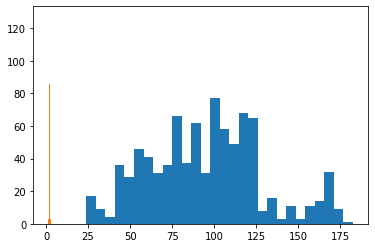

In [17]:
import matplotlib.pyplot as plt
import random
Complete_MPj_no_estm = Complete_MPj[Complete_MPj['is_in_estm'] == 0]
c = plt.hist(estm['MagpieData mean AtomicWeight'].values, bins = 28)
d = plt.hist(estm['MagpieData mean Electronegativity'].values, bins = 28)
samples_atomic = []
samples_electronegativity = []


for i in range(len(c[1])-1):
    samples_atomic.append(random.sample(set(Complete_MPj_no_estm[Complete_MPj_no_estm['MagpieData mean AtomicWeight'].between(c[1][i], c[1][i+1]) == True].index), 
                  int(c[0][i])))
for i in range(len(d[1])-1):
    samples_electronegativity.append(random.sample(set(Complete_MPj_no_estm[Complete_MPj_no_estm['MagpieData mean Electronegativity'].between(d[1][i], d[1][i+1]) == True].index), 
                  int(d[0][i])))

samples_random = random.sample(set(Complete_MPj_no_estm.index), len(estm))

    
idxs_iid_atomic = [item for sublist in samples_atomic for item in sublist]
idxs_iid_electronegativity = [item for sublist in samples_electronegativity for item in sublist]
idxs_random = samples_random

Complete_MPj_iid_atomic = pd.concat([estm[['Components', 'temperature(K)', 'is_in_estm']], 
           Complete_MPj_no_estm[['Components', 'temperature(K)', 'is_in_estm']].loc[idxs_iid_atomic]]).reset_index()[['Components', 'temperature(K)','is_in_estm']]
Complete_MPj_iid_electronegativity = pd.concat([estm[['Components', 'temperature(K)', 'is_in_estm']], 
           Complete_MPj_no_estm[['Components', 'temperature(K)', 'is_in_estm']].loc[idxs_iid_electronegativity]]).reset_index()[['Components', 'temperature(K)', 'is_in_estm']]
Complete_MPj_random = pd.concat([estm[['Components', 'temperature(K)', 'is_in_estm']], 
           Complete_MPj_no_estm[['Components', 'temperature(K)', 'is_in_estm']].loc[idxs_random]]).reset_index()[['Components', 'temperature(K)', 'is_in_estm']]

In [18]:
df_1 = featurizing(Complete_MPj_iid_atomic)
df_1['temperature(K)'] = Complete_MPj_iid_atomic.set_index('Components')['temperature(K)']
df_1['is_in_estm'] = Complete_MPj_iid_atomic.set_index('Components')['is_in_estm']

df_2 = featurizing(Complete_MPj_iid_electronegativity)
df_2['temperature(K)'] = Complete_MPj_iid_electronegativity.set_index('Components')['temperature(K)']
df_2['is_in_estm'] = Complete_MPj_iid_electronegativity.set_index('Components')['is_in_estm']

df_3 = featurizing(Complete_MPj_random)
df_3['temperature(K)'] = Complete_MPj_random.set_index('Components')['temperature(K)']
df_3['is_in_estm'] = Complete_MPj_random.set_index('Components')['is_in_estm']

df_4 = featurizing(Complete_MPj_random)
df_4['temperature(K)'] = Complete_MPj_random.set_index('Components')['temperature(K)']
df_4['is_in_estm'] = 0
for i in range(len(df_4)):
    df_4['is_in_estm'].iloc[i] = np.round(random.random())
#len(df.dropna()) - len(df)

MultipleFeaturizer:   0%|          | 0/1740 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/1740 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/1740 [00:00<?, ?it/s]

MultipleFeaturizer:   0%|          | 0/1740 [00:00<?, ?it/s]

In [19]:
df_1 = df_1.dropna()
df_2 = df_2.dropna()
df_3 = df_3.dropna()
df_4 = df_4.dropna()

In [20]:
train_df_1, test_df_1 = train_test_split(df_1, test_size = 0.2, random_state = 0)
train_df_2, test_df_2 = train_test_split(df_2, test_size = 0.2, random_state = 0)
train_df_3, test_df_3 = train_test_split(df_3, test_size = 0.2, random_state = 0)
train_df_4, test_df_4 = train_test_split(df_4, test_size = 0.2, random_state = 0)

In [21]:
def create_model(train_df):
    
    '''Pipeline for ETC-vanilla'''
    etc = ExtraTreesClassifier(random_state = 0)
    pipe = Pipeline([
        ('decorrelation', MyDecorrelator(0.9)), 
        ('threshold', VarianceThreshold(threshold = 0)), 
        ('feature_selector', SelectPercentile(f_classif)), 
        ('etc', etc)
    ], verbose = 1)
    param_grid = {
        "etc__n_estimators": [100, 250, 500],    #Tune the number of estimators
        "etc__max_features": [1, 0.75, 0.5],  #Tune the number of features to consider when looking for the best split
        "feature_selector__percentile": [50, 75, 100]       #Tune the percentage of features to retain in terms of f_regression score
    }

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0)
    search = GridSearchCV(pipe, param_grid, n_jobs=1, verbose = 1, cv = stratified_kfold)
    search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

    return search

In [22]:
model_1 = create_model(train_df_1)
model_2 = create_model(train_df_2)
model_3 = create_model(train_df_3)
model_4 = create_model(train_df_4)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.6s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.6s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.6min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   3.2s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.5s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   2.4s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.5min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.6s
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.1s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.7s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.3s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   5.0s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   4.9s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   5.2s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   1.8s
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipel

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  3.9min finished


[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.3s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.0s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etc, total=   0.9s


In [23]:
#plt.hist(df_3[df_3['is_in_SuperCon'] == 1]['MagpieData mean Electronegativity'], bins=28, alpha = 0.5)
#plt.hist(df_3[df_3['is_in_SuperCon'] == 0]['MagpieData mean Electronegativity'], bins=28, alpha = 0.5)

In [24]:
test_predictions_1 = model_1.predict(test_df_1.iloc[:, :-1]) 
test_predictions_2 = model_2.predict(test_df_2.iloc[:, :-1]) 
test_predictions_3 = model_3.predict(test_df_3.iloc[:, :-1])
test_predictions_4 = model_4.predict(test_df_4.iloc[:, :-1])

test_labels_1 = test_df_1.iloc[:, -1].values
test_labels_2 = test_df_2.iloc[:, -1].values
test_labels_3 = test_df_3.iloc[:, -1].values
test_labels_4 = test_df_4.iloc[:, -1].values

test_proba_predictions_1 = model_1.predict_proba(test_df_1.iloc[:, :-1]) 
test_proba_predictions_2 = model_2.predict_proba(test_df_2.iloc[:, :-1]) 
test_proba_predictions_3 = model_3.predict_proba(test_df_3.iloc[:, :-1]) 
test_proba_predictions_4 = model_4.predict_proba(test_df_4.iloc[:, :-1]) 

fpr1, tpr1, thresholds1 = roc_curve(test_labels_1, test_proba_predictions_1.transpose()[1]) 
fpr2, tpr2, thresholds1 = roc_curve(test_labels_2, test_proba_predictions_2.transpose()[1])
fpr3, tpr3, thresholds3 = roc_curve(test_labels_3, test_proba_predictions_3.transpose()[1]) 
fpr4, tpr4, thresholds4 = roc_curve(test_labels_4, test_proba_predictions_4.transpose()[1])

print('F1 =', f1_score(test_labels_1, test_predictions_1), 
     'AUC =', roc_auc_score(test_df_1['is_in_estm'], test_proba_predictions_1.transpose()[1]))
print('F1 =', f1_score(test_labels_2, test_predictions_2), 
     'AUC =', roc_auc_score(test_df_2['is_in_estm'], test_proba_predictions_2.transpose()[1]))
print('F1 =',  f1_score(test_labels_3, test_predictions_3), 
     'AUC =', roc_auc_score(test_df_3['is_in_estm'], test_proba_predictions_3.transpose()[1]))
print('F1 =', f1_score(test_labels_4, test_predictions_4), 
     'AUC =', roc_auc_score(test_df_4['is_in_estm'], test_proba_predictions_4.transpose()[1]))

F1 = 0.983050847457627 AUC = 0.9991247192495706
F1 = 0.9829545454545454 AUC = 0.9986127625842252
F1 = 0.9885714285714285 AUC = 0.9974402166732727
F1 = 0.46987951807228917 AUC = 0.48901734104046246


In [25]:
model_3.best_params_

{'etc__max_features': 0.75,
 'etc__n_estimators': 100,
 'feature_selector__percentile': 100}

In [26]:
X_train_3 = train_df_3.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df_3.iloc[:, :-1]).get_support()]
X_test_3 = test_df_3[X_train_3.columns]

correlated_features = set()  
corr_matrix = X_train_3.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train_3 = X_train_3.drop(labels=correlated_features, axis=1)
X_test_3 = X_test_3[X_train_3.columns]
y_train_3 = train_df_3.iloc[:, -1]
y_test_3 = test_df_3.iloc[:, -1]

In [27]:
etc_3 = ExtraTreesClassifier(random_state=0, n_estimators = 100, max_features = 0.75)
etc_3.fit(X_train_3, y_train_3)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features=0.75,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [28]:
import shap
explainer = shap.TreeExplainer(etc_3)
shap_values = explainer.shap_values(X_test_3)

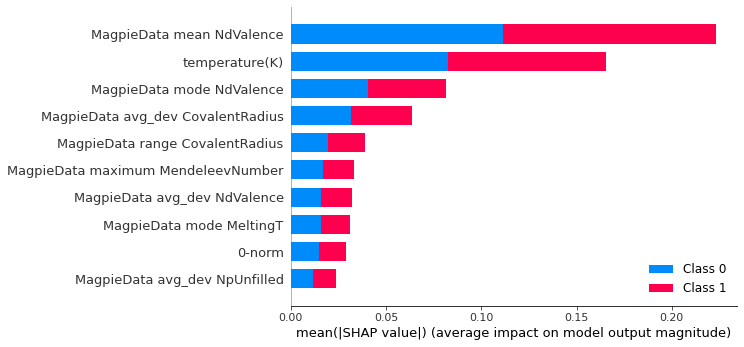

In [29]:
shap.summary_plot(shap_values, X_test_3, max_display = 10)

In [30]:
Output_shap_class1 = pd.DataFrame(shap_values[0], index = X_test_3.index, columns = X_test_3.columns)
Output_shap_class2 = pd.DataFrame(shap_values[1], index = X_test_3.index, columns = X_test_3.columns)

In [31]:
Output_shap_mean_class1 = pd.DataFrame(abs(Output_shap_class1).describe().loc['mean']/sum(abs(Output_shap_class1).describe().loc['mean'])).sort_values('mean', ascending = False)
Output_shap_mean_class2 = pd.DataFrame(abs(Output_shap_class2).describe().loc['mean']/sum(abs(Output_shap_class2).describe().loc['mean'])).sort_values('mean', ascending = False)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


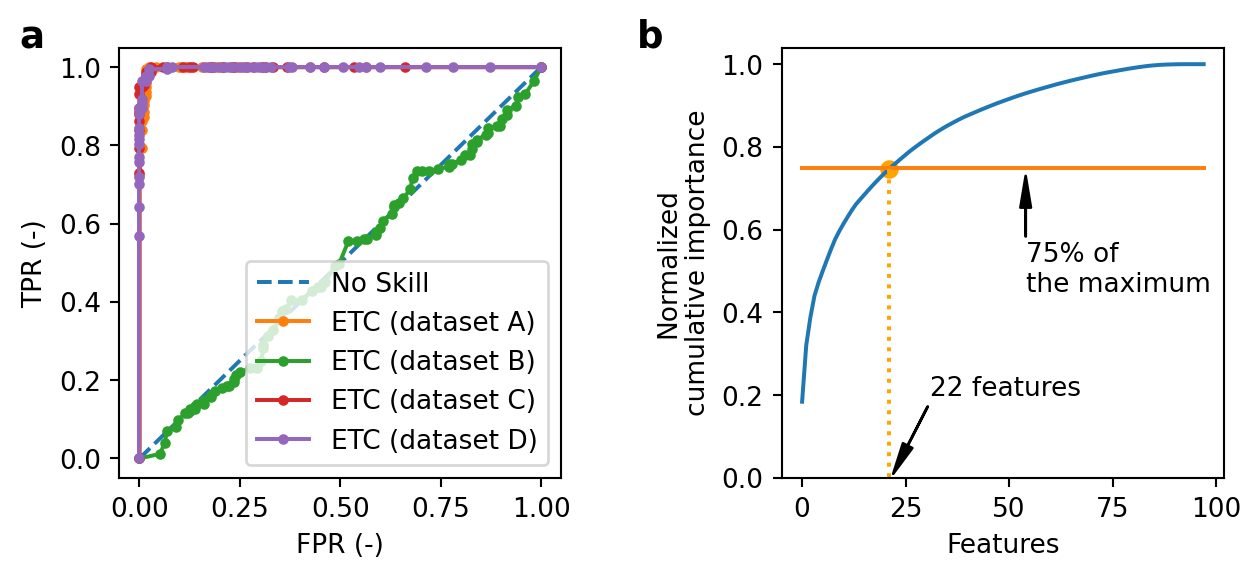

In [32]:
N = np.shape(X_test_3)[1]
k = 0.75
import matplotlib.pyplot as plt
#cumsum = np.cumsum(Output_shap_mean_class1)
normalized_cumulative = np.cumsum(Output_shap_mean_class1)/(np.max(np.cumsum(Output_shap_mean_class1)))

                                                                                       
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3), dpi = 190)
ax[0].plot([0,1], [0,1], linestyle='--', label='No Skill')
ax[0].plot(fpr3, tpr3, marker='.', label='ETC (dataset A)', alpha = 1)
ax[0].plot(fpr4, tpr4, marker='.', label='ETC (dataset B)', alpha = 1)
ax[0].plot(fpr1, tpr1, marker='.', label='ETC (dataset C)', alpha = 1)
ax[0].plot(fpr2, tpr2, marker='.', label='ETC (dataset D)', alpha = 1)


ax[0].set_xlabel('FPR (-)')
ax[0].set_ylabel('TPR (-)')
ax[0].annotate(r'$\mathbf{a}$', xy = (0, 0), xytext = (-.3, 1.05), fontsize = 14)
ax[0].legend()

ax[1].plot(np.arange(N), normalized_cumulative)
ax[1].plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k))
#plt.yticks(np.array([0, 0.5, 1]))

ax[1].annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax[1].annotate('75% of\nthe maximum', xy=(54, 0.73), xytext=(54, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax[1].scatter(ind_cross1, normalized_cumulative.iloc[ind_cross1], color = 'orange')
ax[1].plot((ind_cross1, ind_cross1), (normalized_cumulative.iloc[ind_cross1], 0), color = 'orange', ls = ':')
ax[1].set_ylim(0, 1.04)
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Normalized\ncumulative importance')
ax[1].annotate(r'$\mathbf{b}$', xy = (0, 0), xytext = (-40, 1.04), fontsize = 14)

fig.subplots_adjust(wspace = .5)

#plt.savefig('C:\\Users\\giovanni\\Desktop\\ETC_result.pdf', bbox_inches = 'tight')

#
#plt.show()



plt.show()

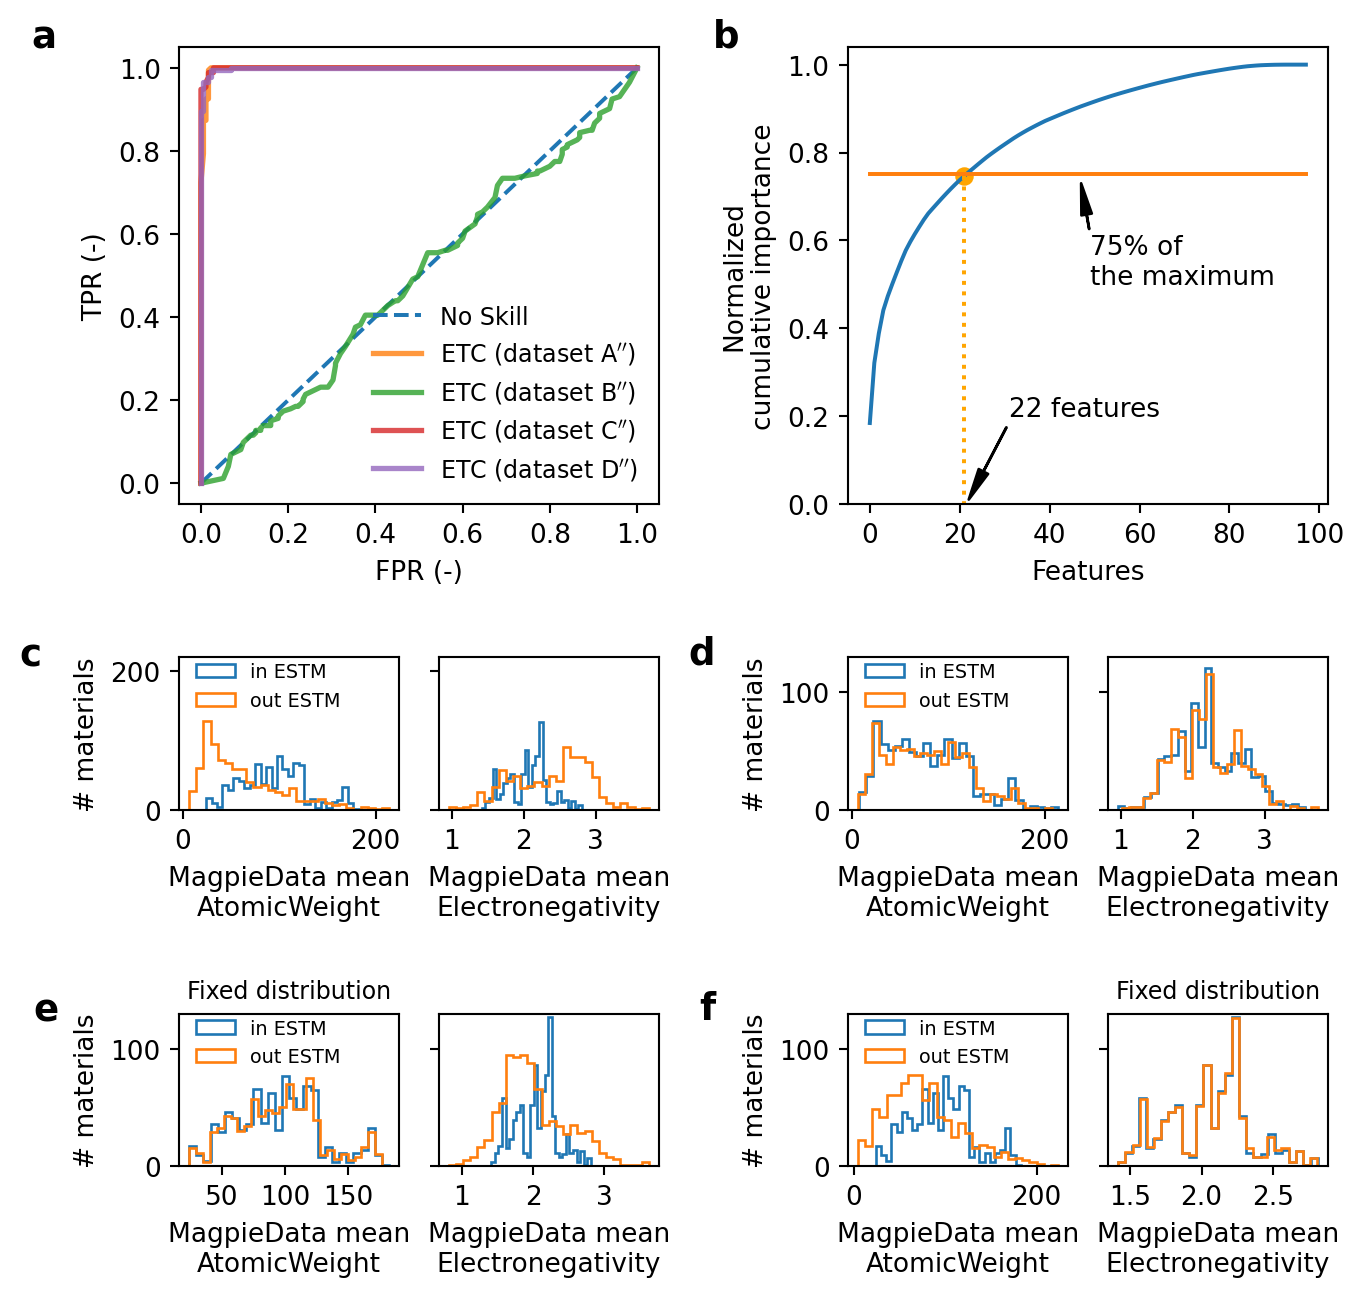

In [35]:
from matplotlib.pyplot import GridSpec
from matplotlib import gridspec
fig = plt.figure(1, figsize=(7.8, 7.8), dpi = 190)

gs = gridspec.GridSpec(5,5, width_ratios=[1,1,0.5,1,1], height_ratios=[.9, 0.15, 0.3, 0.25, 0.3])
#gridspec = dict(1, 5, width_ratios=[1, 1, .03, 1, 1])

ax5 = plt.subplot(gs[0, :2])
ax5.plot([0,1], [0,1], linestyle='--', label='No Skill')
alpha = .8
ax5.plot(fpr3, tpr3, linewidth = 2, label='ETC (dataset A$^{\prime \prime}$)', alpha = alpha)
ax5.plot(fpr4, tpr4, linewidth = 2, label='ETC (dataset B$^{\prime \prime}$)', alpha = alpha)
ax5.plot(fpr1, tpr1, linewidth = 2, label='ETC (dataset C$^{\prime \prime}$)', alpha = alpha)
ax5.plot(fpr2, tpr2, linewidth = 2, label='ETC (dataset D$^{\prime \prime}$)', alpha = alpha)
ax5.set_xlabel('FPR (-)')
ax5.set_ylabel('TPR (-)')
ax5.annotate(r'$\mathbf{a}$', xy = (0, 0), xytext = (-.39, 1.05), fontsize = 14)
ax5.legend(fontsize = 9, frameon = False)

ax6 = plt.subplot(gs[0, 3:5])
ax6.plot(np.arange(N), normalized_cumulative)
ax6.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k))
ax6.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax6.annotate('75% of\nthe maximum', xy=(47, 0.73), xytext=(49, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax6.scatter(ind_cross1, normalized_cumulative.iloc[ind_cross1], color = 'orange')
ax6.plot((ind_cross1, ind_cross1), (normalized_cumulative.iloc[ind_cross1], 0), color = 'orange', ls = ':')
ax6.set_ylim(0, 1.04)
ax6.set_xlabel('Features')
ax6.set_ylabel('Normalized\ncumulative importance')
ax6.annotate(r'$\mathbf{b}$', xy = (0, 0), xytext = (-35, 1.04), fontsize = 14)


ax7 = plt.subplot(gs[2, 0])
ax7.hist(df_3[df_3['is_in_estm'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in ESTM')
ax7.hist(df_3[df_3['is_in_estm'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out ESTM')
ax7.set_ylim(0, 220)
ax7.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax7.set_ylabel('# materials')
ax7.annotate(r'$\mathbf{c}$', xy = (20, 20), xytext = (-170, 210), fontsize = 14)
ax7.set_xlabel('MagpieData mean\nAtomicWeight')
ax8 = plt.subplot(gs[2, 1])
ax8.hist(df_3[df_3['is_in_estm'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.hist(df_3[df_3['is_in_estm'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax8.set_ylim(0, 220)
ax8.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax8.set_xlabel('MagpieData mean\nElectronegativity')


ax9 = plt.subplot(gs[2, 3])
ax9.hist(df_4[df_4['is_in_estm'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in ESTM')
ax9.hist(df_4[df_4['is_in_estm'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out ESTM')
ax9.set_ylim(0, 130)
ax9.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
#ax3.set_title('Result distribution', fontsize = 9)
ax9.set_ylabel('# materials')
ax9.annotate(r'$\mathbf{d}$', xy = (20, 20), xytext = (-170, 125), fontsize = 14)
ax9.set_xlabel('MagpieData mean\nAtomicWeight')
ax10 = plt.subplot(gs[2, 4])
ax10.hist(df_4[df_4['is_in_estm'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.hist(df_4[df_4['is_in_estm'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax10.set_ylim(0, 130)
ax10.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
#ax4.set_title('Fixed distribution', fontsize = 9)
ax10.set_xlabel('MagpieData mean\nElectronegativity')

ax1 = plt.subplot(gs[4, 0])
ax1.set_title('Fixed distribution', fontsize = 9)
ax1.hist(df_1[df_1['is_in_estm'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in ESTM')
ax1.hist(df_1[df_1['is_in_estm'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out ESTM')
ax1.set_ylim(0, 130)
ax1.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
ax1.set_ylabel('# materials')
ax1.annotate(r'$\mathbf{e}$', xy = (20, 20), xytext = (-100, 125), fontsize = 14)
ax1.set_xlabel('MagpieData mean\nAtomicWeight')
ax2 = plt.subplot(gs[4, 1])
ax2.hist(df_1[df_1['is_in_estm'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.hist(df_1[df_1['is_in_estm'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax2.set_ylim(0, 130)
ax2.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax2.set_xlabel('MagpieData mean\nElectronegativity')



ax3 = plt.subplot(gs[4, 3])
ax3.hist(df_2[df_2['is_in_estm'] == 1]['MagpieData mean AtomicWeight'], bins = 28, histtype='step', label = 'in ESTM')
ax3.hist(df_2[df_2['is_in_estm'] == 0]['MagpieData mean AtomicWeight'], bins = 28 , histtype='step', label = 'out ESTM')
ax3.set_ylim(0, 130)
ax3.legend(frameon = False, fontsize = 7.3, loc='upper left', bbox_to_anchor=(0, .58, 0.5, 0.5))
#ax3.set_title('Result distribution', fontsize = 9)
ax3.set_ylabel('# materials')
ax3.annotate(r'$\mathbf{f}$', xy = (0, 0), xytext = (-170, 125), fontsize = 14)
ax3.set_xlabel('MagpieData mean\nAtomicWeight')
ax4 = plt.subplot(gs[4, 4])
ax4.hist(df_2[df_2['is_in_estm'] == 1]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.hist(df_2[df_2['is_in_estm'] == 0]['MagpieData mean Electronegativity'], bins = 28 , histtype='step')
ax4.set_ylim(0, 130)
ax4.tick_params(bottom=True, labelbottom=True, left=True, labelleft=False)
ax4.set_title('Fixed distribution', fontsize = 9)
ax4.set_xlabel('MagpieData mean\nElectronegativity')
plt.show()
